In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from utils import *
import numpy as np 

mu0 = 1
var0 = 0.5 

x = np.random.normal(3, 1, 1000)

N_qbits = 9
Nodes = 9 * 2

C_G = nx.complete_graph(Nodes)
W_G = nx.Graph()

Nodes_category = {a: b for a, b in zip(range(Nodes), ['a'] * (Nodes//2) + ['b'] * (Nodes//2))}
Nodes_labels = {a: b for a, b in zip(range(Nodes), list(range(-7, 2))[::-1] * 2)}

In [2]:
for edge in C_G.edges:
    node1, node2 = edge
    if Nodes_category[node1] == Nodes_category[node2] == 'a':
        pi = Nodes_labels[node1]
        pj = Nodes_labels[node2]
        w = - 2**(pi+pj)*fAA(var0)
        
        W_G.add_edge(node1, node2, bij=w)
    elif Nodes_category[node1] == Nodes_category[node2] == 'b':
        pi = Nodes_labels[node1]
        pj = Nodes_labels[node2]
        w = - np.sum(2**(pi+pj)*fBB(x, mu0, var0))
        
        W_G.add_edge(node1, node2, bij=w)
    else:
        pi = Nodes_labels[node1]
        pj = Nodes_labels[node2]
        w = - np.sum(2**(pi+pj)*fAB(x, mu0, var0))
        
        W_G.add_edge(node1, node2, bij=w)


In [3]:
node_weights = np.zeros(W_G.number_of_nodes())
for node in C_G.nodes:
    if Nodes_category[node] == 'a':
        p = Nodes_labels[node]
        w = -np.sum(2**p * fA(x, mu0, var0) + (2**(2*p - 1) - 2**p*mu0)*fAA(var0) - 2**p*var0*fAB(x, mu0, var0))
        
        node_weights[node] = w
    else:
        p = Nodes_labels[node]
        w = -np.sum(2**p * fB(x, mu0, var0) + (2**(2*p - 1) - 2**p*var0)*fBB(x, mu0, var0) - 2**p*var0*fAB(x, mu0, var0))
        
        node_weights[node] = w

nx.set_node_attributes(W_G, {a:{'ai':b} for a, b in zip(C_G.nodes, node_weights)})

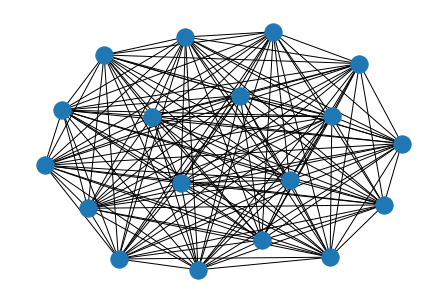

In [4]:
nx.draw(W_G)

In [5]:
from dwave.system import DWaveSampler, EmbeddingComposite, DWaveCliqueSampler
import dimod
import dwave.inspector

bqm = dimod.from_networkx_graph(W_G, vartype='BINARY', edge_attribute_name='weight', node_attribute_name='weight')

sampleset = EmbeddingComposite(DWaveSampler()).sample(bqm, num_reads=10000)

In [6]:
a_s = np.zeros(len(sampleset.record)) 
b_s = np.zeros(len(sampleset.record))

for k, rec in enumerate(sampleset.record):
    states = rec[0]
    mu = 0
    var = 0
    for i in range(states.size):
        if Nodes_category[i] == 'a':
            mu = mu + 2**(Nodes_labels[i]) * states[i]
        else:
            var = var + 2**(Nodes_labels[i]) * states[i]
            
    a_s[k] = mu
    b_s[k] = var

In [7]:
a_s.mean(), b_s.mean()

(2.27604140625, 2.04307265625)

(array([ 116.,  125.,  188.,  422.,  330.,  411.,  509.,  332.,  595.,
        1343., 1084.,   95.,  112.,  159.,  324.,  268.,  354.,  411.,
         244.,  486., 1189.,  903.]),
 array([0.        , 0.18146307, 0.36292614, 0.5443892 , 0.72585227,
        0.90731534, 1.08877841, 1.27024148, 1.45170455, 1.63316761,
        1.81463068, 1.99609375, 2.17755682, 2.35901989, 2.54048295,
        2.72194602, 2.90340909, 3.08487216, 3.26633523, 3.4477983 ,
        3.62926136, 3.81072443, 3.9921875 ]),
 <BarContainer object of 22 artists>)

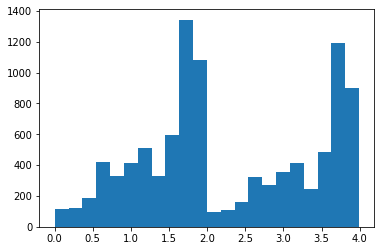

In [8]:
import matplotlib.pyplot as plt

plt.hist(a_s, bins='auto')

(array([140., 386., 745., 285., 557., 782., 249., 424., 451., 335., 939.,
        113., 341., 653., 231., 466., 729., 216., 388., 426., 271., 873.]),
 array([0.        , 0.18146307, 0.36292614, 0.5443892 , 0.72585227,
        0.90731534, 1.08877841, 1.27024148, 1.45170455, 1.63316761,
        1.81463068, 1.99609375, 2.17755682, 2.35901989, 2.54048295,
        2.72194602, 2.90340909, 3.08487216, 3.26633523, 3.4477983 ,
        3.62926136, 3.81072443, 3.9921875 ]),
 <BarContainer object of 22 artists>)

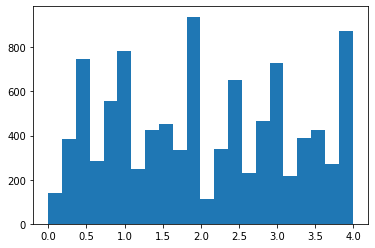

In [9]:
plt.hist(b_s, bins='auto')